In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psi(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

In [3]:
'''
Método de Crank-Nicolson para a solução da equação de Schrödinger em uma única dimensão
    ih * u_t = h_2/2m * u_xx + V_xt * u

Com as condições de contorno não incluídas nessa etapa para que o controle preditivo faça as alterações
Com a equação inicial sendo decidida pelos polinômios de hermite de primeiro e segundo grau

u(x,0) = 0.80 * psi(0, x) + 0.60 * psi(1,x)

A interpretação foi ajustada a partir do código em python da Msc. Mirian Silva
'''

def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 1000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    us = np.linspace(-5, 5, 1000)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2+us #V(x,u(t))

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psi(0, xs) + 0.60 * psi(1,xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return (psi_c, ts, xs)

psi, ts, xs = CrankNicolson(M = 1000, O = -5, L = 5, T = 10)

In [4]:
def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    #print(type(n))
    Pxt = N(n)*Hn(x.real)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [5]:
def ExactSolution(M, T = 1000, L = 5):
    N = 1000

    xs = np.linspace(-5, L, M)
    ts = np.linspace(0, N/100, T)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.01):
        for j in np.arange(0, 10, 0.01):
            psiExato[r][int(round(j*100,1))] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1

    #psiExato = 1/np.sqrt(2)*psixt(0,xs,ts)+1/np.sqrt(2)*psixt(1,xs,ts)

    return (psiExato, ts, xs)

In [6]:
vetor = []

In [7]:
psi_d = np.zeros((1000,1000))
psi_d, p, r = ExactSolution(M = 1000)
print(psi_d[1])

[-1.26026468e-05+0.00000000e+00j -1.25866031e-05+6.58998144e-07j
 -1.25385083e-05+1.31646865e-06j -1.24584705e-05+1.97088728e-06j
 -1.23466701e-05+2.62073662e-06j -1.22033588e-05+3.26450943e-06j
 -1.20288594e-05+3.90071204e-06j -1.18235648e-05+4.52786765e-06j
 -1.15879375e-05+5.14451967e-06j -1.13225081e-05+5.74923491e-06j
 -1.10278746e-05+6.34060682e-06j -1.07047007e-05+6.91725864e-06j
 -1.03537146e-05+7.47784643e-06j -9.97570707e-06+8.02106208e-06j
 -9.57153000e-06+8.54563627e-06j -9.14209434e-06+9.05034124e-06j
 -8.68836810e-06+9.53399360e-06j -8.21137423e-06+9.99545692e-06j
 -7.71218830e-06+1.04336443e-05j -7.19193613e-06+1.08475207e-05j
 -6.65179130e-06+1.12361055e-05j -6.09297252e-06+1.15984745e-05j
 -5.51674091e-06+1.19337618e-05j -4.92439722e-06+1.22411622e-05j
 -4.31727893e-06+1.25199328e-05j -3.69675726e-06+1.27693943e-05j
 -3.06423415e-06+1.29889331e-05j -2.42113911e-06+1.31780025e-05j
 -1.76892604e-06+1.33361236e-05j -1.10907003e-06+1.34628868e-05j
 -4.43064038e-07+1.355795

In [8]:
print(psi_d[2])

[-1.32158815e-05+0.00000000e+00j -1.31990522e-05+6.91224808e-07j
 -1.31486020e-05+1.38084713e-06j -1.30646445e-05+2.06726805e-06j
 -1.29473689e-05+2.74889580e-06j -1.27970392e-05+3.42414929e-06j
 -1.26139940e-05+4.09146168e-06j -1.23986456e-05+4.74928381e-06j
 -1.21514790e-05+5.39608771e-06j -1.18730509e-05+6.03036998e-06j
 -1.15639885e-05+6.65065517e-06j -1.12249882e-05+7.25549904e-06j
 -1.08568136e-05+7.84349181e-06j -1.04602945e-05+8.41326130e-06j
 -1.00363244e-05+8.96347598e-06j -9.58585898e-06+9.49284795e-06j
 -9.10991359e-06+1.00001358e-05j -8.60956134e-06+1.04841475e-05j
 -8.08593050e-06+1.09437429e-05j -7.54020207e-06+1.13778362e-05j
 -6.97360714e-06+1.17853987e-05j -6.38742412e-06+1.21654610e-05j
 -5.78297595e-06+1.25171148e-05j -5.16162711e-06+1.28395154e-05j
 -4.52478063e-06+1.31318834e-05j -3.87387492e-06+1.33935064e-05j
 -3.21038061e-06+1.36237408e-05j -2.53579726e-06+1.38220130e-05j
 -1.85165002e-06+1.39878206e-05j -1.15948626e-06+1.41207340e-05j
 -4.60872103e-07+1.422039

In [9]:
print(psi[0:1000][0])

[-9.63658608e-06+0.00000000e+00j  7.17693356e-06+1.27181413e-06j
 -8.30641724e-06-1.28034637e-06j  6.37558835e-06+1.81312310e-06j
 -7.66096967e-06-1.75047566e-06j  5.78388716e-06+2.20891904e-06j
 -7.17673034e-06-2.01257301e-06j  5.30853987e-06+2.53325869e-06j
 -6.76502380e-06-2.17332347e-06j  4.91269050e-06+2.80981087e-06j
 -6.39470614e-06-2.27567756e-06j  4.57519714e-06+3.04912166e-06j
 -6.05262143e-06-2.34152062e-06j  4.28166939e-06+3.25785909e-06j
 -5.73261856e-06-2.38265599e-06j  4.02192382e-06+3.44156800e-06j
 -5.43116793e-06-2.40534289e-06j  3.78901202e-06+3.60527368e-06j
 -5.14545224e-06-2.41282825e-06j  3.57855375e-06+3.75336466e-06j
 -4.87265825e-06-2.40692837e-06j  3.38807731e-06+3.88935402e-06j
 -4.60987368e-06-2.38898009e-06j  3.21637530e-06+4.01575847e-06j
 -4.35423551e-06-2.36032822e-06j  3.06295477e-06+4.13414338e-06j
 -4.10311806e-06-2.32249614e-06j  2.92763862e-06+4.24528752e-06j
 -3.85425716e-06-2.27717634e-06j  2.81032871e-06+4.34939232e-06j
 -3.60578400e-06-2.226152

In [10]:
print(psi_d[0:1000][0])

[-1.20165997e-05+0.00000000e+00j -1.20013067e-05+6.28208365e-07j
 -1.19554620e-05+1.25496059e-06j -1.18791689e-05+1.87880380e-06j
 -1.17725992e-05+2.49829158e-06j -1.16359929e-05+3.11198726e-06j
 -1.14696575e-05+3.71846707e-06j -1.12739678e-05+4.31632334e-06j
 -1.10493644e-05+4.90416765e-06j -1.07963533e-05+5.48063390e-06j
 -1.05155043e-05+6.04438139e-06j -1.02074501e-05+6.59409776e-06j
 -9.87288473e-06+7.12850200e-06j -9.51256209e-06+7.64634723e-06j
 -9.12729412e-06+8.14642352e-06j -8.71794912e-06+8.62756060e-06j
 -8.28544981e-06+9.08863044e-06j -7.83077122e-06+9.52854982e-06j
 -7.35493859e-06+9.94628269e-06j -6.85902503e-06+1.03408425e-05j
 -6.34414918e-06+1.07112945e-05j -5.81147270e-06+1.10567576e-05j
 -5.26219768e-06+1.13764067e-05j -4.69756397e-06+1.16694742e-05j
 -4.11884644e-06+1.19352517e-05j -3.52735213e-06+1.21730920e-05j
 -2.92441733e-06+1.23824102e-05j -2.31140465e-06+1.25626849e-05j
 -1.68969992e-06+1.27134599e-05j -1.06070919e-06+1.28343446e-05j
 -4.25855513e-07+1.292501

In [11]:
def FuncDE(x):
    return 1/np.sqrt(2) * psixt(0, x[0], x[1]) + 1/np.sqrt(2) * psixt(1, x[0], x[1])

#Avaliação do gradiente
def gradiente(x, funcDA):
    h = 0.01
    grad = []
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + 0.0 + h
        # Deve haver uma conversão de posição da matriz para ponto da curva
        dx = ((FuncDE(xh)-funcDA[int(np.round(((xh[0]+5)*100),0))][int(np.round((xh[1]*100),0))])**2) - ((FuncDE(x)-funcDA[int(np.round(((xh[0]+5)*100),0))][int(np.round((x[1]*100),0))])**2)/h
        grad.append(dx.real)
    return grad

#Método gradiente
def methodGrad(x):
    k = 0
    kmax = 5000
    #x = np.array([-3/2., 5/2.])
    
    while(k < kmax):
        d = -1*np.array(gradiente(x, psi))
        alpha = 0.01
        x = x + alpha*d
        k += 1
        
    x_otimo = x
    return x_otimo

Considerando que a nossa função objetivo é a diferença entre a função exata e o psi estudado até o momento, utilizamos o método gradiente para estimar o valor de x e de t para que alcance o valor ideal. No primeiro teste considerou-se -5 e 0, onde -5 envolve o valor de x e de u, já que V, o potêncial harmônico depende destes. Então, para que se alcance o valor exato é preciso variar o x e o t em pequenos valores, em intervalos de $10^{-3}$.

Para o algoritmo MPC é necessário realizar o método gradiente algumas vezes e utilizar sempre o primeiro termo e posteriormente fazê-lo para todo o tempo estudado. 

Toda vez que obtemos um conjunto de valores do método gradiente, utilizamos o primeiro para realizar a operação $$\psi_{i+1}=V[A] \cdot \psi_i$$ Esse próximo fator será utilizado no Crank-Nicolson e o método gradiente se tornará necessário.

In [12]:
def CrankNicolsonSimplificado(psi_c, M, O = 0, L = 1, T = 0.5):
    N = 1000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    us = np.linspace(-5, 5, 1000)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2+us #V(x,u(t))

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    #plt.plot(xs, np.absolute(psi_c[0:M, 0:1000])**2)
    return (psi_c, ts, xs)

In [13]:
def FuncDE(x):
    return 1/np.sqrt(2) * psixt(0, x[0], x[1]) + 1/np.sqrt(2) * psixt(1, x[0], x[1])

#Avaliação do gradiente
def gradiente(x, funcDA):
    h = 0.01
    grad = []
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + 0.0 + h
        # Deve haver uma conversão de posição da matriz para ponto da curva
        dx = (FuncDE(xh)-funcDA[int(np.round(((xh[0]+5)*100),0))][int(np.round((xh[1]*100),0))]) - (FuncDE(x)-funcDA[int(np.round(((xh[0]+5)*100),0))][int(np.round((x[1]*100),0))])/h
        grad.append(dx.real)
    return grad

#Método gradiente
def methodGrad(x, psi):
    k = 0
    kmax = 5000
    #x = np.array([-3/2., 5/2.])
    
    while(k < kmax):
        d = -1*np.array(gradiente(x, psi))
        alpha = 0.01
        x = x + alpha*d
        k += 1
        
    x_otimo = x
    return x_otimo

In [14]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psi(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    #print(type(n))
    Pxt = N(n)*Hn(x.real)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

[-0.61882727  0.09061121]
[-1.73371879  0.04634239]
[-1.85944446  0.019469  ]
[-2.52495082 -0.46723099]
[-2.31319935 -0.34200808]
[-0.57115442  0.92384151]
[-4.93358108 -2.38463717]
[-1.67236952  0.54455347]
[-1.72106915  0.14442038]
[-0.46811217  0.9322666 ]
[-4.88644788 -1.50421623]
[-4.99489873 -2.8949801 ]
[-1.38220345  0.50726198]
[-0.81510894 -0.10350422]
[-4.65755123 -1.40339776]
[-4.97510294 -2.93519772]
[-0.79101287  1.25248747]
[-0.4268694  -0.10961728]
[-0.68268309  0.00672667]
[-1.56330025  0.16481913]


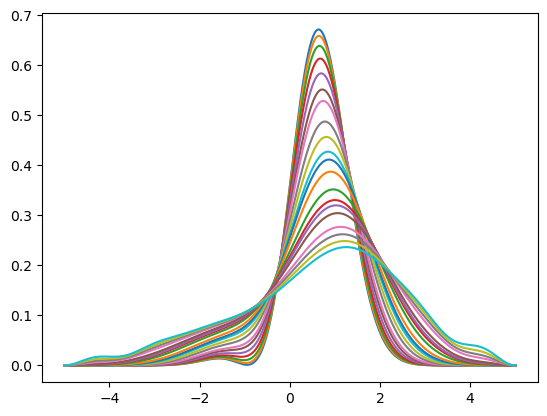

In [15]:
ps = np.zeros((1000, 1000))
psi_c = np.zeros((1000, 1000))
ps[:,0] = 0.80 * psi(0, xs) + 0.60 * psi(1,xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
psi_c = ps.astype(complex)
psi, ts, xs = CrankNicolsonSimplificado(psi_c, M = 1000, O = -5, L = 5, T = 10)

i = 0
y = np.array([-2.0,0.0])
t = y.copy()
for u in range(20):
    for i in range(i, i+3):
        vetor.append(methodGrad(y, psi))
        y[0] = y[0] + 0.01
    A = vetor[0]
    print(A)
    i+=1
    vetor = []
    t[0] = t[0] + 0.01
    y = t.copy()
    
    
    #Retorno dos números em um intervalo
    xs = np.linspace(-5, 5, 1000)
    ts = np.linspace(0, 10, 1000)
    us = np.linspace(-5, 5, 1000)

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = 10/(P*1000-1) 

    #Discretização temporal
    t0, tF = 0, 10
    dt = (tF - t0)/(P*1000-1)
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*(A[0])**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    M = 1000
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    for k in range(1, 1000):
        b = np.matmul(matrizB, np.array(psi[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
    
    plt.plot(xs, np.absolute(psi[0:M, i])**2)
    #psi, ts, xs = CrankNicolsonSimplificado(psi, M = 1000, O = -5, L = 5, T = 10)


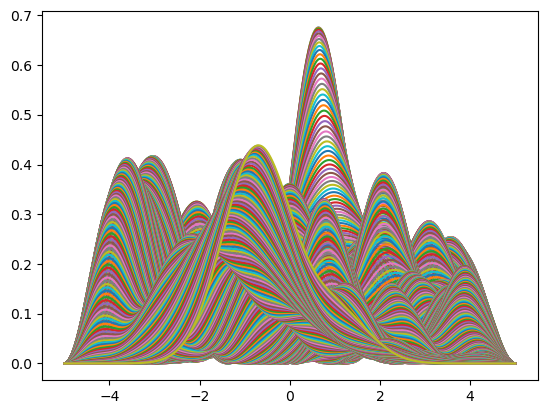

In [16]:
for i in range(0,999):
    plt.plot(xs, np.absolute(psi[0:M, i])**2)

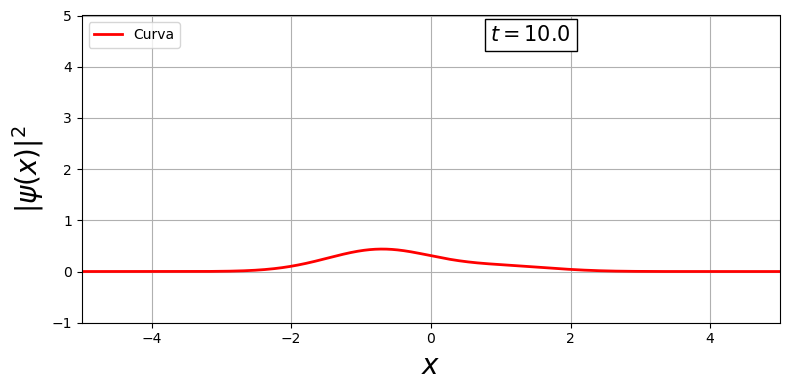

In [17]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    ln1.set_data(xs, np.absolute(psi[0:1000,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Curva')
time_text = ax.text(0.85, 4.5, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 5)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=200)
ani.save('QuantControl.gif',writer='pillow',fps=50,dpi=100)

In [18]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psi(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    #print(type(n))
    Pxt = N(n)*Hn(x.real)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [ ]:
ps = np.zeros((1000, 1000))
psi_c = np.zeros((1000, 1000))
ps[:,0] = 0.80 * psi(0, xs) + 0.60 * psi(1,xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
psi_c = ps.astype(complex)
psi, ts, xs = CrankNicolsonSimplificado(psi_c, M = 1000, O = -5, L = 5, T = 10)

i = 0
y = np.array([-2.0,0.0])
t = y.copy()
for u in range(20):
    for i in range(i, i+3):
        vetor.append(methodGrad(y, psi))
        y[0] = y[0] + 0.01
    A = vetor[0]
    print(A)
    i+=1
    vetor = []
    t[0] = t[0] + 0.01
    y = t.copy()
    
    
    #Retorno dos números em um intervalo
    xs = np.linspace(-5, 5, 1000)
    ts = np.linspace(0, 10, 1000)
    us = np.linspace(-5, 5, 1000)

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = 10/(P*1000-1) 

    #Discretização temporal
    t0, tF = 0, 10
    dt = (tF - t0)/(P*1000-1)
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*(A[0])**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    M = 1000
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    for k in range(1, 1000):
        b = np.matmul(matrizB, np.array(psi[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
    
    plt.plot(xs, np.absolute(psi[0:M, i])**2)
    psi, ts, xs = CrankNicolsonSimplificado(psi, M = 1000, O = -5, L = 5, T = 10)


[-0.61882727  0.09061121]
[-7.10590164e-01 -1.99350785e-04]
[-0.82909123 -0.11278724]
[-0.6352856   0.07585257]
[-0.73555472 -0.01913451]
[-0.81760049 -0.10518666]
[-0.78205543 -0.06806631]
[-0.80170266 -0.08564372]
[-0.64317186  0.06777102]
[-0.63478168  0.07146763]
[-0.83311601 -0.1159676 ]
[-0.84071237 -0.12462518]


In [ ]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    ln1.set_data(xs, np.absolute(psi[0:1000,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Curva')
time_text = ax.text(0.85, 4.5, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 5)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=200)
ani.save('QuantControl2.gif',writer='pillow',fps=50,dpi=100)